# Requirements: 

In [1]:
import pandas as pd
import numpy
import os
import os.path 
import matplotlib.pyplot as plt
import matplotlib.colors
import copy
import errno
import glob
import time
import calendar
import json
import pickle
import random
import netCDF4
from numpy import savez_compressed
from optparse import OptionParser
from scipy.interpolate import (UnivariateSpline, RectBivariateSpline, RegularGridInterpolator)


from tensorflow.python.client import device_lib
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow 
tensorflow.compat.v1.disable_eager_execution()

#import keras
#from keras import backend as K
#import tensorflow


def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

import utils

import warnings
warnings.filterwarnings('ignore')

In [2]:
g1 = ['g1']*108
g2 = ['g2']*96
g3 = ['g3']*108
g4 = ['g4']*60
g5 = ['g5']*12
group_id = g1+g2+g3+g4+g5
#group_id = [g1, g2, g3, g4, g5]
len(group_id)

384

In [3]:
permut = pd.read_csv('./NewR.csv')
print(len(permut))

770


In [7]:
t = 0

new_df = pd.DataFrame(columns = ['feature', 'hss-mean', 'hss_std'])

f, m, s = [],[],[]

for i in range(int(len(permut)/2)):
    f_name = permut.loc[t]['Feature']
    #print(f_name)
    mean_hss = permut.loc[t]['HSS_mean']
    std_hss  = permut.loc[t]['HSS_std']
    
    f.append(f_name)
    m.append(mean_hss)
    s.append(std_hss)
    #leadtime = 

    t = t+2
    
new_df['feature']  = f  
new_df['hss-mean'] = m
new_df['hss_std']  = s
new_df.to_csv('./P.csv')

In [ ]:
permut = pd.read_csv('./P.csv')
permut.iat[329,2] = 0.465420
permut['Score'] = numpy.abs((permut['hss-mean']*100) - 52)
permut = permut.drop(index = 384)
permut['groups'] = group_id
#permut.loc[329]['hss-mean'] = 0.465420
permut
permut.to_csv('./f.csv')

In [3]:
permut = pd.read_csv('./f.csv')

In [5]:
group_scores = list(permut.groupby('groups')['Score'].sum())
group_names  = ['G1', 'G2', 'G3', 'G4', 'G5']

group_df = pd.DataFrame(columns = ['Group', 'Score'])
group_df['Group'] = group_names
group_df['Score'] = group_scores
group_df

,Group,Score
0,G1,116.676174
1,G2,77.286715
2,G3,73.791939
3,G4,92.408727
4,G5,21.725385


In [ ]:
fig, axs = plt.subplots(figsize = (8, 6))
ax = sns.barplot(x="Group", y="Score", data=group_df, ci=None, ax = axs)

#plt.xticks(rotation=90, fontsize = 12)
plt.tight_layout()

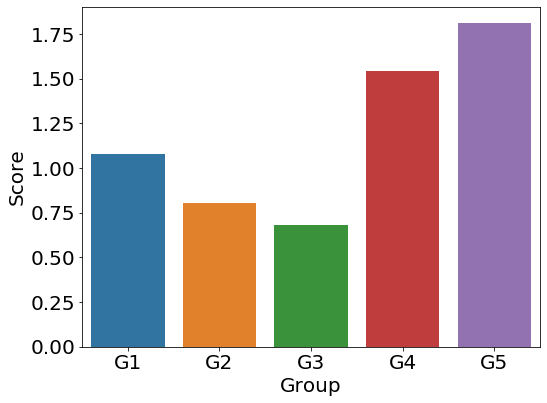

In [41]:
fig, axs = plt.subplots(figsize = (8, 6))
ax = sns.barplot(x="Group", y="Score", data=group_df, ci=None, ax = axs)

#plt.xticks(rotation=90, fontsize = 12)
plt.tight_layout()

In [24]:
permut.iat[329,2]

0.2654205093919717

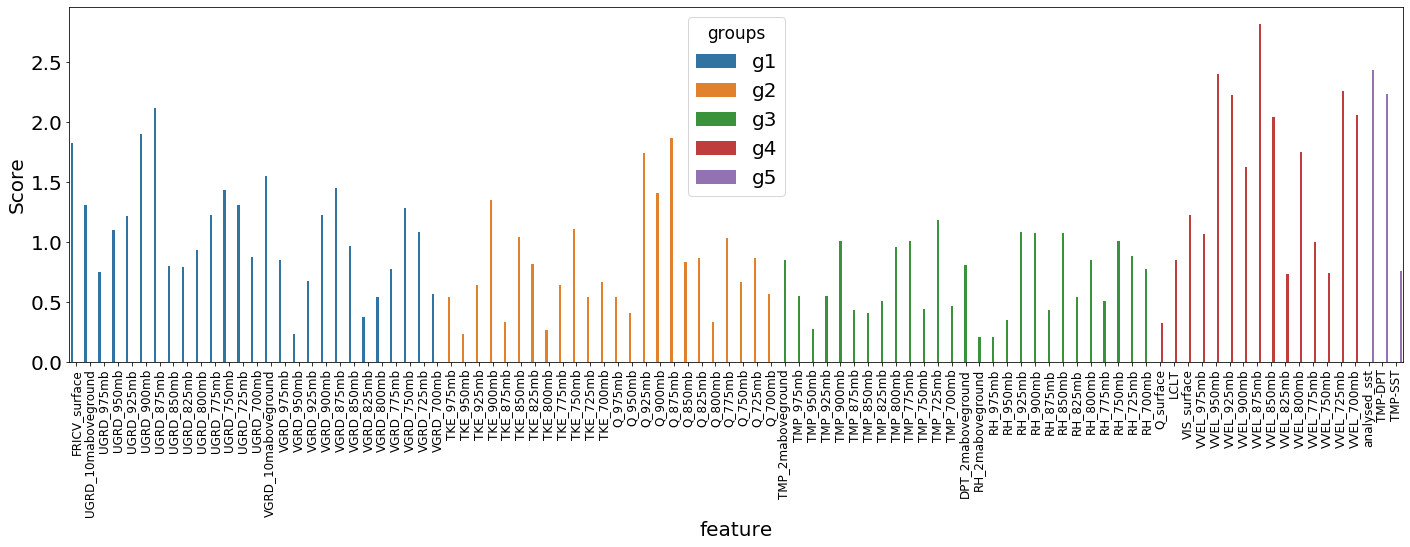

In [29]:
import seaborn as sns
fig, axs = plt.subplots(figsize = (20, 8))
ax = sns.barplot(x="feature", y="Score", data=permut, hue= 'groups', ci=None, ax = axs)

plt.xticks(rotation=90, fontsize = 12)
plt.tight_layout()

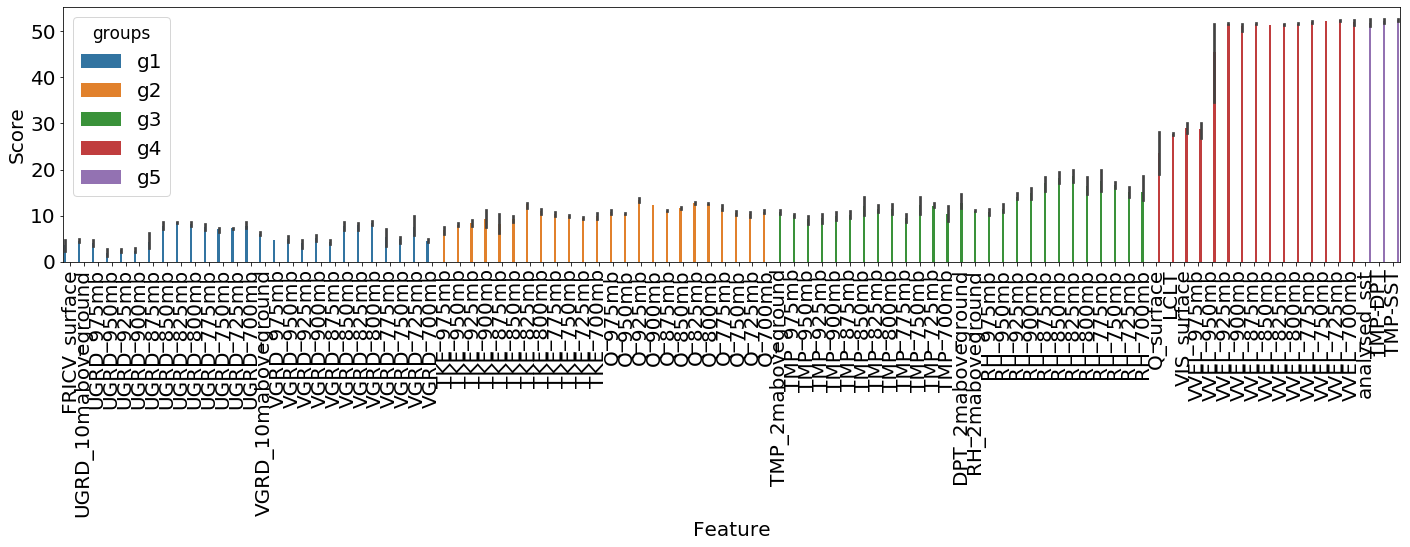

In [25]:
import seaborn as sns
fig, axs = plt.subplots(figsize = (20, 8))
ax = sns.barplot(x="Feature", y="Score", data=permut, hue= 'groups', ax = axs)

plt.xticks(rotation=90)
plt.tight_layout()

In [2]:
available_devices = device_lib.list_local_devices()
available_gpus =  [x.name for x in available_devices if x.device_type == 'GPU']
available_xla_gpus =  [x.name for x in available_devices if x.device_type == 'XLA_GPU']

print("Devices:")
print("    requested {} GPUs".format(4))
print("    available GPUs: {} (XLA: {})".format(len(available_gpus), len(available_xla_gpus)))
nGPU = min(len(available_gpus), 4)
print("    will use {} GPUs".format(4))

Devices:
    requested 4 GPUs
    available GPUs: 0 (XLA: 0)
    will use 4 GPUs


In [3]:
DEFAULT_IMAGE_DIR_NAME = ('/data1/fog-data/fog-maps/')
DEFAULT_TARGET_DIR_NAME = ('/data1/fog/fognn/Dataset/TARGET/')

DEFAULT_CUBES_24_DIR_NAME = ('/data1/fog/fognn/Dataset/24HOURS/INPUT/')
DEFAULT_TARGET_24_DIR_NAME = ('/data1/fog/fognn/Dataset/24HOURS/TARGET/')

DEFAULT_LINE_COLOUR = numpy.array([228, 26, 28], dtype=float) / 255
DEFAULT_LINE_WIDTH = 3
DEFAULT_RANDOM_LINE_COLOUR = numpy.full(3, 152. / 255)
DEFAULT_RANDOM_LINE_WIDTH = 2

LEVELS_FOR_CONTOURS = numpy.linspace(0, 1, num=11, dtype=float)

FIGURE_WIDTH_INCHES = 10
FIGURE_HEIGHT_INCHES = 10

FONT_SIZE = 20
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('xtick', labelsize=FONT_SIZE)
plt.rc('ytick', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE)
plt.rc('figure', titlesize=FONT_SIZE)

## Pretrained FogNet

In [ ]:
############################
# Setup input data rasters #
############################
# Generate data file paths
trainYearIdxs = [4, 5, 6, 7, 8]
valYearIdxs   = [0, 1, 2, 3]
testYearIdxs  = [9, 10, 11]

horizons = [6, 12, 24]
allYears = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


nam_G1_template = "NETCDF_NAM_CUBE_{year}_PhG1_{horizon}.npz"
nam_G1_names = [nam_G1_template.format(year=year, horizon=horizons[2]) for year in allYears]

nam_G2_template = "NETCDF_NAM_CUBE_{year}_PhG2_{horizon}.npz"
nam_G2_names = [nam_G2_template.format(year=year, horizon=horizons[2]) for year in allYears]

nam_G3_template = "NETCDF_NAM_CUBE_{year}_PhG3_{horizon}.npz"
nam_G3_names = [nam_G3_template.format(year=year, horizon=horizons[2]) for year in allYears]

nam_G4_template = "NETCDF_NAM_CUBE_{year}_PhG4_{horizon}.npz"
nam_G4_names = [nam_G4_template.format(year=year, horizon=horizons[2]) for year in allYears]

mixed_file_template = "NETCDF_MIXED_CUBE_{year}_{horizon}.npz"
mixed_file_names = [mixed_file_template.format(year=year, horizon=horizons[2]) for year in allYears]

mur_file_template = "NETCDF_SST_CUBE_{year}.npz"
mur_file_names = [mur_file_template.format(year=year) for year in allYears]

targets_file_template = "target{year}_{horizon}.csv"
targets_file_names = [targets_file_template.format(year=year, horizon=horizons[2]) for year in allYears]


# Read data cubes
training_list   = utils.load_Cat_cube_data(nam_G1_names,
    nam_G2_names, nam_G3_names, nam_G4_names, mixed_file_names, mur_file_names, DEFAULT_CUBES_24_DIR_NAME, trainYearIdxs)
validation_list = utils.load_Cat_cube_data(nam_G1_names,
    nam_G2_names, nam_G3_names, nam_G4_names, mixed_file_names, mur_file_names, DEFAULT_CUBES_24_DIR_NAME, valYearIdxs)
testing_list    = utils.load_Cat_cube_data(nam_G1_names,
    nam_G2_names, nam_G3_names, nam_G4_names, mixed_file_names, mur_file_names, DEFAULT_CUBES_24_DIR_NAME, testYearIdxs)

target_class = utils.targets(
    targets_file_names, trainYearIdxs, valYearIdxs, testYearIdxs,
    DEFAULT_TARGET_24_DIR_NAME,
    0, # priority_calss: the last integer value is the class of target to predict: 0: is < 1600; 1: < 3200 and 2: < 6400
)
target_list = target_class.binary_target()

# Separate into train, test, validation
Training_targets = target_list[0]
print('training target shape:', Training_targets.shape)
ytrain = target_list[1]
print('training categorical target shape:', ytrain.shape)
Validation_targets = target_list[2]
print('validation target shape:', Validation_targets.shape)
yvalid = target_list[3]
print('validation categorical target shape:', yvalid.shape)
Testing_targets = target_list[4]
print('testing target shape:', Testing_targets.shape)
ytest = target_list[5]
print('testing categorical target shape:', ytest.shape)

In [ ]:
import FogNet
import FogNetConfig
from tensorflow import keras
#from tensorflow import keras
from keras.models import Input, Model   

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Initialize
learningRate = 0.0009 # hyperparameters[key][0] 
wd           = 0.001  # hyperparameters[key][1] 
filters      = 24     # hyperparameters[key][2] 
dropout      = 0.3    # hyperparameters[key][3] 
cnn_file_name = '/data1/fog/fognn/FogNet/trained_model/single_gpu_weights.h5'

C  = FogNet.FogNet(
    Input(training_list[0].shape[1:]),
    Input(training_list[1].shape[1:]),
    Input(training_list[2].shape[1:]),
    Input(training_list[3].shape[1:]),
    Input(training_list[4].shape[1:]),
    Input(training_list[5].shape[1:]),
    filters, dropout, 2)
cnn_model_object = C.BuildModel()
#model.summary() 

cnn_model_object.load_weights(cnn_file_name)  

cnn_model_object.compile(optimizer=Adam(lr=learningRate, decay=wd),
      loss='categorical_crossentropy',
      metrics=['accuracy'])


In [24]:
#cnn_model_object.summary()

## Saliency Map

In [9]:
day = 658

predictor_matrixs = utils.get_predicto_matrix_day(testing_list, day)

list_of_saliency_matrices = utils.get_saliency_for_class(cnn_model_object, target_class = 0, 
                                                         list_of_input_matrices = predictor_matrixs)

#### Results for class 0

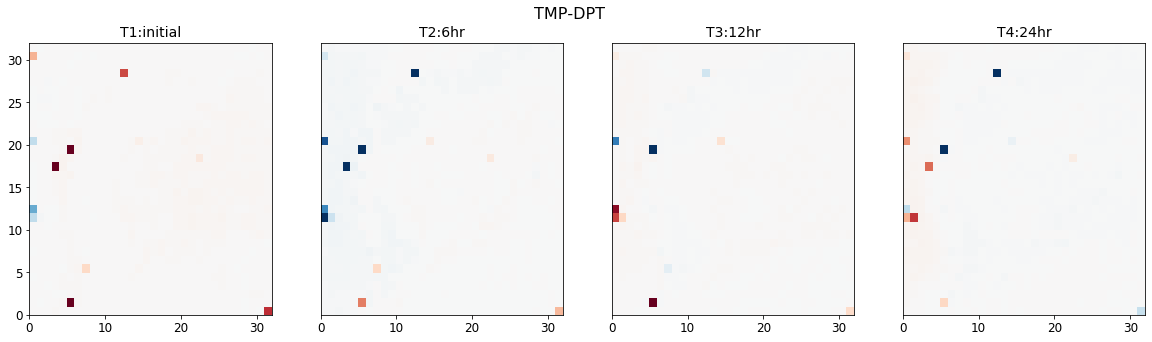

In [9]:
day = 658
_ = utils.plot_saliency_predictor_time(testing_list, list_of_saliency_matrices, day, 
                                 group='Mixed', 
                                 predictor = utils.NETCDF_TMPDPT, 
                                 cmap = utils.SALIENCY_COLOUR_MAP_OBJECT, 
                                 plot_mode = None)

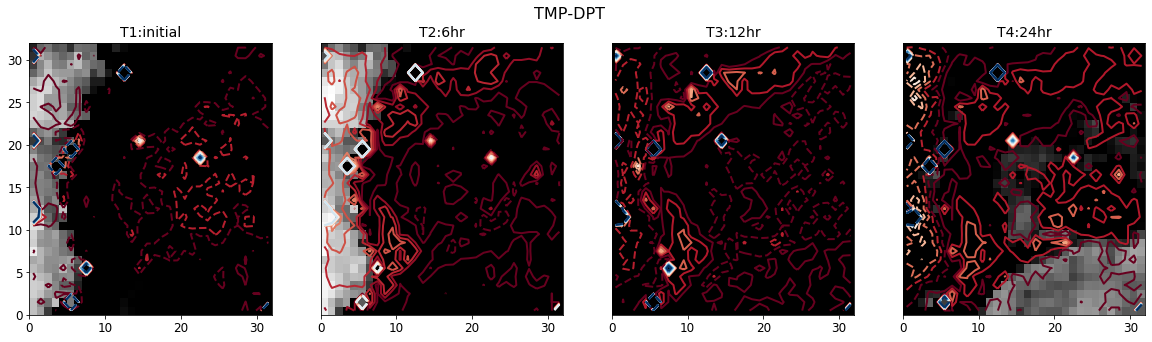

In [15]:
day = 658
_ = utils.plot_saliency_predictor_time(testing_list, list_of_saliency_matrices, day, 
                                 group='Mixed', 
                                 predictor = utils.NETCDF_TMPDPT, 
                                 cmap = utils.SALIENCY_COLOUR_MAP_OBJECT, 
                                 plot_mode = 'C')

# GradCAM

In [13]:
target_layer_names = ['p_re_lu_45', 'concatenate_38', 'concatenate_40']

In [30]:
# Create loss tensor.
output_layer_object = cnn_model_object.layers[-1].output
num_output_neurons = output_layer_object.get_shape().as_list()[-1]

if num_output_neurons == 1:
    if target_class == 1:
        # loss_tensor = model_object.layers[-1].output[..., 0]
        loss_tensor = cnn_model_object.layers[-1].input[..., 0]
    else:
        # loss_tensor = -1 * model_object.layers[-1].output[..., 0]
        loss_tensor = -1 * cnn_model_object.layers[-1].input[..., 0]
else:
    # loss_tensor = model_object.layers[-1].output[..., target_class]
    loss_tensor = cnn_model_object.layers[-1].input[..., 0]

# Create gradient function.
target_layer_activation_tensor = cnn_model_object.get_layer(
    name='concatenate_40'
).output

In [31]:
target_layer_activation_tensor.shape

TensorShape([None, 32, 32, 5, 48])

In [49]:
gradient_tensor = utils._compute_gradients(
    loss_tensor, [target_layer_activation_tensor]
)[0]
gradient_tensor = utils._normalize_tensor(gradient_tensor)

gradient_tensor.shape

TensorShape([None, 32, 32, 5, 48])

In [34]:
if isinstance(cnn_model_object.input, list):
    list_of_input_tensors = cnn_model_object.input
else:
    list_of_input_tensors = [cnn_model_object.input]

gradient_function = K.function(
    list_of_input_tensors, [target_layer_activation_tensor, gradient_tensor]
)

In [40]:
# Evaluate gradient function.
target_layer_activation_matrix, gradient_matrix = gradient_function(
    predictor_matrixs)

target_layer_activation_matrix = target_layer_activation_matrix[0, ...]
gradient_matrix = gradient_matrix[0, ...]

gradient_matrix.shape

(32, 32, 5, 48)

In [47]:
np.sum(gradient_matrix)

0.0

In [55]:
# Compute class-activation matrix.
mean_weight_by_filter = numpy.mean(gradient_matrix, axis=(0, 1))
class_activation_matrix = numpy.ones(
    target_layer_activation_matrix.shape[:-1])

mean_weight_by_filter[0,:].shape

(48,)

In [54]:
num_filters = mean_weight_by_filter.shape[1]
num_filters

48

In [53]:
target_layer_activation_matrix.shape

(32, 32, 5, 48)

In [65]:
for i in range(5):
    x = mean_weight_by_filter[0,i] * target_layer_activation_matrix[:,:,0, i]
    x+=(x+1)
    print(x.shape)


(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)


In [74]:
for m in range(num_filters):
    class_activation_matrix = mean_weight_by_filter[:,m] * target_layer_activation_matrix[:,:,:, m]
    class_activation_matrix += class_activation_matrix

In [75]:
class_activation_matrix.shape

(32, 32, 5)

In [71]:
spatial_dimensions = numpy.array(
    predictor_matrixs[0].shape[1:-1], dtype=int)

print(predictor_matrixs[0].shape[1:-1])
print(spatial_dimensions.shape)

(32, 32, 108)
(3,)


In [76]:
class_activation_matrix = utils._upsample_cam(
    class_activation_matrix=class_activation_matrix,
    new_dimensions=spatial_dimensions)

class_activation_matrix[class_activation_matrix < 0.] = 0.

In [82]:
len(predictor_matrixs)

6

In [86]:
class_activation_matrix = run_gradcam(
    model_object=cnn_model_object,
    list_of_input_matrices= predictor_matrixs,
    target_class=0, target_layer_name=target_layer_names[0])

In [87]:
class_activation_matrix.shape

(32, 32, 108)

In [78]:
day = 658
_ = utils.plot_saliency_predictor_time(testing_list, class_activation_matrix, day, 
                                 group='G1', 
                                 predictor = utils.NETCDF_UGRD_10m, 
                                 cmap = utils.SALIENCY_COLOUR_MAP_OBJECT, 
                                 plot_mode = None)

IndexError: too many indices for array: array is 2-dimensional, but 5 were indexed

# BWO

In [10]:
optimized_predictor_matrix_norm = utils.bwo_for_class(
    cnn_model_object=cnn_model_object, target_class=0,
    init_function_or_matrices=predictor_matrixs)

Loss after 0 of 200 iterations: 6.06e-05
Loss after 100 of 200 iterations: 4.86e-09
Loss after 200 iterations: 3.13e-09


In [12]:
#optimized_predictor_matrix = utils.denormalize_images(
#    predictor_matrix=optimized_predictor_matrix_norm,
#    predictor_names=predictor_names, normalization_dict=normalization_dict)

In [1]:
day = 658
_ = utils.plot_saliency_predictor_time(testing_list, optimized_predictor_matrix_norm, day, 
                                 group='Mixed', 
                                 predictor = utils.NETCDF_SST, 
                                 cmap = utils.SALIENCY_COLOUR_MAP_OBJECT, 
                                 plot_mode = 'C')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

NameError: name 'utils' is not defined

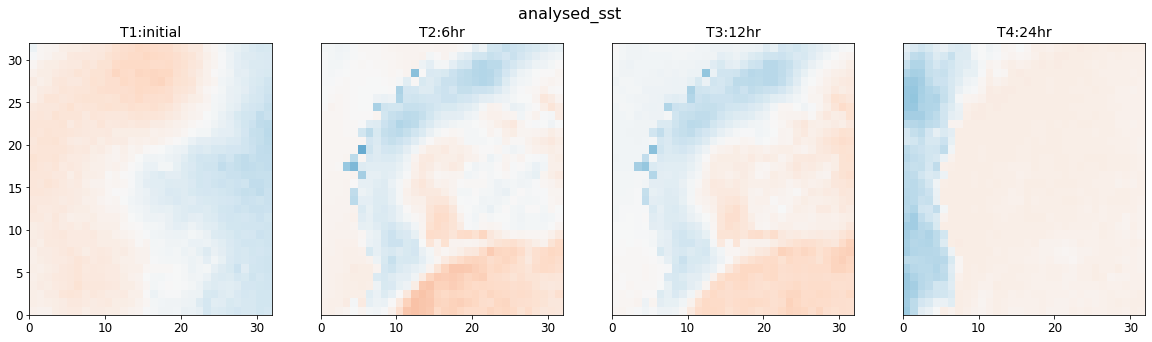

In [19]:
day = 658
_ = utils.plot_saliency_predictor_time(testing_list, optimized_predictor_matrix_norm, day, 
                                 group='Mixed', 
                                 predictor = utils.NETCDF_SST, 
                                 cmap = utils.SALIENCY_COLOUR_MAP_OBJECT, 
                                 plot_mode = None) 